<a href="https://colab.research.google.com/github/HwangBoSungHun/UpGAN/blob/main/UpGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import library 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 51kB/s 
     |████████████████████████████████| 419kB 38.5MB/s 
     |████████████████████████████████| 3.0MB 37.3MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.0.0-alpha0'

In [ ]:
# To generate GIFs
!pip install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 2. Data load and preprocessing

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
car_idx = np.where(train_labels == 9)[0]
car_images = train_images[car_idx,]

In [ ]:
car_images.shape

(5000, 32, 32, 3)

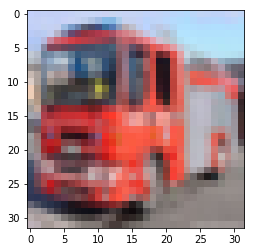

In [ ]:
plt.imshow(car_images[100])

In [ ]:
# Convert RGB to Gray img
gray_images = np.trunc(0.2989 * car_images[:,:,:, 0] + 0.5870 * car_images[:,:,:,1] + 0.1140 * car_images[:,:,:,2])
gray_images = gray_images.astype('uint8')

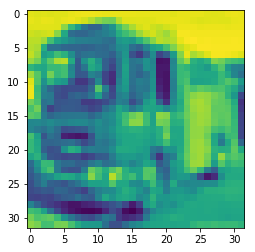

In [ ]:
plt.imshow(gray_images[100])

In [ ]:
gray_images.shape

(5000, 32, 32)

In [ ]:
dw_size = 30

In [ ]:
from PIL import Image
down_images = np.zeros(shape = (gray_images.shape[0], dw_size, dw_size))
for i in range(0, gray_images.shape[0]):
  img = Image.fromarray(gray_images[i])
  down_images[i] = np.array(img.resize((dw_size, dw_size)))

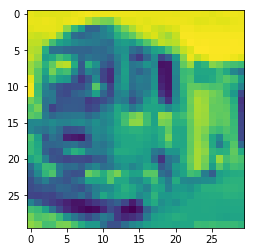

In [ ]:
plt.imshow(down_images[100])

In [ ]:
up_imgs = gray_images.reshape(gray_images.shape[0], 32, 32, 1).astype('float32')
up_imgs = (up_imgs - 127.5) / 127.5 # Normalize the images to [-1, 1]
dw_imgs = down_images.reshape(down_images.shape[0], dw_size, dw_size, 1).astype('float32')
dw_imgs = (dw_imgs - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
print(up_imgs.shape)
print(dw_imgs.shape)

(5000, 32, 32, 1)
(5000, 30, 30, 1)


In [ ]:
dw_imgs_input = dw_imgs.reshape(dw_imgs.shape[0], dw_size*dw_size)

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
up_dataset = tf.data.Dataset.from_tensor_slices(up_imgs).batch(BATCH_SIZE)
dw_dataset = tf.data.Dataset.from_tensor_slices(dw_imgs_input).batch(BATCH_SIZE)

In [ ]:
print(up_dataset)
print(dw_dataset)

<BatchDataset shapes: (None, 32, 32, 1), types: tf.float32>
<BatchDataset shapes: (None, 900), types: tf.float32>


# Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(dw_size*dw_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

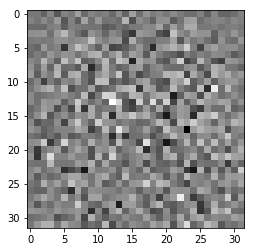

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, dw_size*dw_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040028]], shape=(1, 1), dtype=float32)


# Loss and Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # fake_output 중 discriminator가 1이라고 예측(진짜 이미지다라고 예측)한 것은 generator 입장에서는 잘 생성한 것.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50000
noise_dim = dw_size*dw_size
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(up, dw):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(dw, training=True)

      real_output = discriminator(up, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(upImgs, dwImgs, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for up, dw in zip(upImgs, dwImgs):
      train_step(up, dw)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    # Save the model every 30 epochs
    if (epoch + 1) % 30 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  #generate_and_save_images(generator,epochs,seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
%%time
train(up_dataset, dw_dataset, EPOCHS)

Time for epoch 1329 is 2.66698956489563 sec


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)